<a href="https://colab.research.google.com/github/karaage0703/covid19_memo/blob/master/signate_covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 新型コロナウイルスの感染状況を分析するためのノートブック

データを可視化するために、個人的に作成しているものです。

内容の正確性を保証するものではありませんので、ご注意下さい。


以下リポジトリでPR受付中です。

https://github.com/karaage0703/covid19_memo

## データのダウンロード
SIGNATEのCOVID-19チャレンジ（フェーズ1）で作成されたオープンデータ（Google Spread Sheet)を用いて分析

https://signate.jp/competitions/260

In [5]:
!wget --no-check-certificate --output-document=data.csv 'https://docs.google.com/spreadsheets/d/10MFfRQTblbOpuvOs_yjIYgntpMGBg592dL8veXoPpp4/export?gid=0&format=csv'

--2020-04-12 13:20:09--  https://docs.google.com/spreadsheets/d/10MFfRQTblbOpuvOs_yjIYgntpMGBg592dL8veXoPpp4/export?gid=0&format=csv
Resolving docs.google.com (docs.google.com)... 172.217.204.139, 172.217.204.100, 172.217.204.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data.csv’

data.csv                [ <=>                ]   2.43M  14.0MB/s    in 0.2s    

2020-04-12 13:20:09 (14.0 MB/s) - ‘data.csv’ saved [2548035]



## 死亡率と性別の関係

SIGNATEのフォーラムの以下の分析例を、Google Colaboratoryで動作するように改変

https://signate.jp/competitions/261/discussions/20200401125031-59

データをpandasを使って読み込み、内容を確認する

In [0]:
import pandas as pd

# SIGNATE COVID-2019 Dataset からデータを読み込み、ステータスと性別を抽出
df = pd.read_csv("data.csv")
df = df[["ステータス","性別"]]

# ステータスのフラグを変換
df["ステータス"] = df["ステータス"].replace({0: '罹患中', 1: '回復', 2: '死亡'})

f = lambda x: '{:.2%}'.format(x)

ステータス別の人数と割合

In [7]:
status_cnt = df["ステータス"].value_counts()
status_ratio = df["ステータス"].value_counts(normalize=True).apply(f) 

status_table = pd.concat([status_cnt, status_ratio], axis=1)
status_table.columns= ["人数","割合(%)"]
status_table

,人数,割合(%)
無症状,123,45.05%
軽症,112,41.03%
死亡,26,9.52%
中等症,11,4.03%
重症,1,0.37%


性別の人数と割合

In [8]:
gender_cnt = df["性別"].value_counts()
gender_ratio = df["性別"].value_counts(normalize=True).apply(f)
 
gender_table = pd.concat([gender_cnt, gender_ratio],  axis=1)
gender_table.columns= ["人数","割合"]
gender_table

,人数,割合
男性,3172,59.09%
女性,2095,39.03%
非公表,86,1.60%
不明,14,0.26%
0,1,0.02%


性別による死亡率の違い

In [9]:
df["ステータス"] = df["ステータス"].replace({'罹患中': '生存', "回復": '生存', 2: '死亡'})
ct = pd.crosstab(df["性別"],df["ステータス"])
ct

ステータス,中等症,死亡,無症状,軽症,重症
性別,,,,,
女性,4,7,60,47,0
男性,7,18,61,65,1
非公表,0,1,2,0,0


In [10]:
print("死亡における男性の割合：{:.0%}".format(ct.loc["男性","死亡"]/ct.loc[:,"死亡"].sum()))

死亡における男性の割合：69%


p値の確認

In [11]:
# Fisher's exact test
import scipy.stats as st
_, p = st.fisher_exact(ct[0:2])
print(f'p値 = {p :.3f}')

ValueError: ignored

## Bar Chart Race

以下discussionを参考に都道府県別の累積罹患者数推移をBar Chart Raceを使って可視化
https://signate.jp/competitions/261/discussions/20200401171320-59

matplotlibの日本語化

https://karaage.hatenadiary.jp/entry/2018/12/17/073000

In [12]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 2.7MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.0.5-cp36-none-any.whl size=4118721 sha256=e8cb817c2ff8e229addbb3494b17c6f5d8eb771e77c4b2fa95a3e4e1893b5b29
  Stored in directory: /root/.cache/pip/wheels/6c/8a/08/4a784957da9f3c2b4839b4986be2fba2a481877318948be52c
Successfully built japanize-matplotlib


In [13]:
import japanize_matplotlib

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [0]:
import pandas as pd
import datetime

In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
#import seaborn as sns
#sns.set(font='Yu Gothic', style='white')
#mpl.rcParams['font.family'] = 'YuGothic'

In [0]:
pref_area = {
    "北海道":"北海道",
    "青森県":"東北",
    "岩手県":"東北",
    "宮城県":"東北",
    "秋田県":"東北",
    "山形県":"東北",
    "福島県":"東北",
    "茨城県":"北関東・甲信",
    "栃木県":"北関東・甲信",
    "群馬県":"北関東・甲信",
    "埼玉県":"南関東",
    "千葉県":"南関東",
    "東京都":"南関東",
    "神奈川県":"南関東",
    "新潟県":"北陸",
    "富山県":"北陸",
    "石川県":"北陸",
    "福井県":"北陸",
    "山梨県":"北関東・甲信",
    "長野県":"北関東・甲信",
    "岐阜県":"東海",
    "静岡県":"東海",
    "愛知県":"東海",
    "三重県":"東海",
    "滋賀県":"近畿",
    "京都府":"近畿",
    "大阪府":"近畿",
    "兵庫県":"近畿",
    "奈良県":"近畿",
    "和歌山県":"近畿",
    "鳥取県":"中国",
    "島根県":"中国",
    "岡山県":"中国",
    "広島県":"中国",
    "山口県":"中国",
    "徳島県":"四国",
    "香川県":"四国",
    "愛媛県":"四国",
    "高知県":"四国",
    "福岡県":"九州",
    "佐賀県":"九州",
    "長崎県":"九州",
    "熊本県":"九州",
    "大分県":"九州",
    "宮崎県":"九州",
    "鹿児島県":"九州",
    "沖縄県":"九州"
}

colors = {
    "北海道":'#7db0dd',
    "東北":'#8bade0',
    "北陸":'#99a9e2',
    "北関東・甲信":'#a6a6e2',
    "南関東":'#b1a2e1',
    "東海":'#c59cdc',
    "近畿":'#d497d3',
    "中国":'#de94c6',
    "四国":'#e393b6',
    "九州":'#e495a5'
}

データ整形

In [17]:
# SIGNATE COVID-2019 Dataset をダウンロードして【罹患者】のみをCSVファイルとして用意しておく
# 用意したCSVファイルをpd.DataFrameとして読み込む
df = pd.read_csv('data.csv')
df.shape

(6295, 32)

In [18]:
# 列の絞り込み
df = df.loc[:, ['公表日', '受診都道府県']]
# 公表日か受診都道府県のいずれかが欠損している記録は除外
df.dropna(how='any', inplace=True)
# 公表日をdatetime64型に変換
df['公表日'] = pd.to_datetime(df['公表日'], format='%Y/%m/%d')
# 都道府県フラグ列を追加
df = pd.concat([df, pd.get_dummies(df['受診都道府県'])], axis=1)
df.set_index('公表日', inplace=True)

df.tail()

,受診都道府県,三重県,京都府,佐賀県,兵庫県,北海道,千葉県,和歌山県,埼玉県,大分県,大阪府,奈良県,宮城県,宮崎県,富山県,山口県,山形県,山梨県,岐阜県,岡山県,広島県,徳島県,愛媛県,愛知県,新潟県,東京都,栃木県,沖縄県,滋賀県,熊本県,石川県,神奈川県,福井県,福岡県,福島県,秋田県,群馬県,茨城県,長崎県,長野県,青森県,静岡県,香川県,高知県,鹿児島県
公表日,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-07,沖縄県,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-04-07,沖縄県,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-04-07,沖縄県,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-04-07,沖縄県,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-04-10,兵庫県,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# 日毎の罹患者公表数を集計
df_count = df.resample('D').sum()
df_count.tail()

,三重県,京都府,佐賀県,兵庫県,北海道,千葉県,和歌山県,埼玉県,大分県,大阪府,奈良県,宮城県,宮崎県,富山県,山口県,山形県,山梨県,岐阜県,岡山県,広島県,徳島県,愛媛県,愛知県,新潟県,東京都,栃木県,沖縄県,滋賀県,熊本県,石川県,神奈川県,福井県,福岡県,福島県,秋田県,群馬県,茨城県,長崎県,長野県,青森県,静岡県,香川県,高知県,鹿児島県
公表日,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-06,0.0,0.0,0.0,6.0,0.0,11.0,0.0,10.0,1.0,20.0,0.0,0.0,1.0,1.0,5.0,6.0,5.0,1.0,0.0,1.0,0.0,2.0,11.0,0.0,83.0,0.0,6.0,1.0,0.0,0.0,6.0,6.0,14.0,0.0,0.0,0.0,7.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0
2020-04-07,0.0,0.0,1.0,20.0,4.0,42.0,0.0,0.0,2.0,53.0,0.0,5.0,1.0,3.0,1.0,0.0,0.0,10.0,1.0,0.0,0.0,0.0,21.0,2.0,80.0,3.0,12.0,5.0,1.0,0.0,18.0,6.0,23.0,8.0,0.0,0.0,6.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0
2020-04-08,0.0,0.0,2.0,8.0,10.0,22.0,0.0,0.0,6.0,0.0,2.0,0.0,0.0,1.0,0.0,3.0,0.0,8.0,0.0,0.0,0.0,0.0,20.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0,46.0,7.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2020-04-09,0.0,0.0,0.0,20.0,18.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,5.0,0.0,9.0,0.0,0.0,0.0,0.0,14.0,0.0,178.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,10.0,0.0
2020-04-10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,189.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0


In [20]:
# 日毎の罹患者公表数を累積として集計
df_cumsum = df_count.cumsum()
df_cumsum.tail()

,三重県,京都府,佐賀県,兵庫県,北海道,千葉県,和歌山県,埼玉県,大分県,大阪府,奈良県,宮城県,宮崎県,富山県,山口県,山形県,山梨県,岐阜県,岡山県,広島県,徳島県,愛媛県,愛知県,新潟県,東京都,栃木県,沖縄県,滋賀県,熊本県,石川県,神奈川県,福井県,福岡県,福島県,秋田県,群馬県,茨城県,長崎県,長野県,青森県,静岡県,香川県,高知県,鹿児島県
公表日,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-06,14.0,78.0,8.0,209.0,193.0,168.0,18.0,196.0,33.0,428.0,25.0,23.0,11.0,11.0,12.0,19.0,19.0,59.0,11.0,16.0,3.0,23.0,239.0,35.0,1114.0,17.0,22.0,18.0,20.0,30.0,269.0,52.0,176.0,16.0,11.0,20.0,71.0,12.0,14.0,11.0,9.0,2.0,36.0,3.0
2020-04-07,14.0,78.0,9.0,229.0,197.0,210.0,18.0,196.0,35.0,481.0,25.0,28.0,12.0,14.0,13.0,19.0,19.0,69.0,12.0,16.0,3.0,23.0,260.0,37.0,1194.0,20.0,34.0,23.0,21.0,30.0,287.0,58.0,199.0,24.0,11.0,20.0,77.0,13.0,14.0,12.0,9.0,2.0,38.0,3.0
2020-04-08,14.0,78.0,11.0,237.0,207.0,232.0,18.0,196.0,41.0,481.0,27.0,28.0,12.0,15.0,13.0,22.0,19.0,77.0,12.0,16.0,3.0,23.0,280.0,39.0,1194.0,20.0,34.0,25.0,22.0,30.0,333.0,65.0,203.0,29.0,11.0,20.0,77.0,13.0,14.0,12.0,9.0,3.0,39.0,3.0
2020-04-09,14.0,78.0,11.0,257.0,225.0,232.0,18.0,196.0,41.0,481.0,29.0,28.0,12.0,16.0,13.0,27.0,19.0,86.0,12.0,16.0,3.0,23.0,294.0,39.0,1372.0,20.0,34.0,25.0,22.0,30.0,333.0,70.0,203.0,33.0,11.0,20.0,81.0,13.0,14.0,13.0,9.0,3.0,49.0,3.0
2020-04-10,14.0,78.0,11.0,258.0,225.0,232.0,18.0,196.0,41.0,481.0,29.0,28.0,12.0,16.0,13.0,27.0,19.0,86.0,12.0,16.0,3.0,23.0,294.0,39.0,1561.0,20.0,34.0,25.0,22.0,30.0,333.0,70.0,203.0,33.0,11.0,20.0,81.0,13.0,14.0,13.0,9.0,3.0,54.0,3.0


In [0]:
# 累積罹患者公表数の多い10都道府県を日毎に集計
patient_report = {}
for _, se in df_cumsum.iterrows():
    patient_report[se.name.date()] = se.sort_values(ascending=False).head(10)

In [22]:
# 例）2020/03/20時点の累積罹患者を表示
patient_report[datetime.date(2020, 3, 20)]

北海道     157.0
愛知県     139.0
大阪府     123.0
東京都     102.0
兵庫県     101.0
神奈川県     71.0
埼玉県      45.0
千葉県      42.0
新潟県      25.0
京都府      23.0
Name: 2020-03-20 00:00:00, dtype: float64

可視化

In [0]:
# Bar Chart Race描画用の関数の作成
def draw_barchart(date):
    data = patient_report[date].sort_values()
    ax.clear()
    ax.barh(data.index, data.values, color=[colors[pref_area[x]] for x in data.index])
    
    for i, (name, value) in enumerate(zip(data.index, data.values)):
        area = pref_area[name]
        ax.text(value, i, name, size=14, weight=600, ha='right', va='bottom')
        ax.text(value, i-.25, area, size=10, color='#444444', ha='right', va='baseline')
        ax.text(value, i, value, size=14, ha='left',  va='bottom')

    ax.text(1, 0.4, data.name.date(), transform=ax.transAxes,color='#777777', size=38, ha='right', weight=800)
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
#    plt.xlim(0, 600)
    plt.box(False)

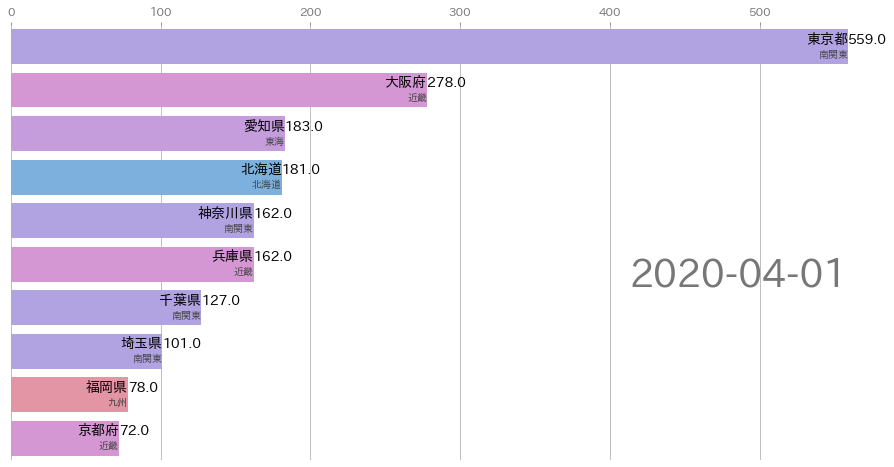

In [24]:
# 例）2020/03/20時点の累積罹患者を表示
fig, ax = plt.subplots(figsize=(15, 8))
draw_barchart(datetime.date(2020, 4, 1))

アニメGIFを作成するためにimagemagickをインストール

参考：https://qiita.com/shinmura0/items/ed96863281637e4fa10c

In [25]:
!apt-get install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g

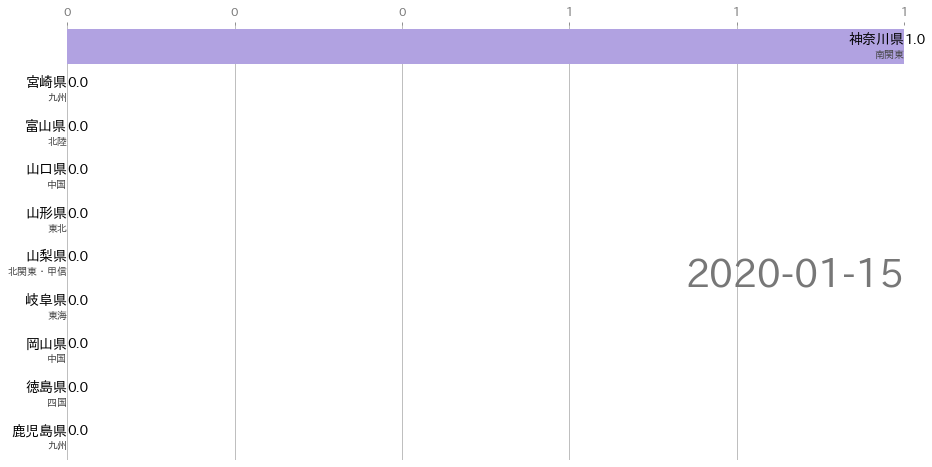

In [26]:
# 罹患者推移をgifファイルとして保存
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=list(patient_report.keys()))
animator.save('output.gif', writer="imagemagick")

In [0]:
from google.colab import files
files.download('output.gif')

# References